In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from  tqdm import tqdm

import torch
import torchvision
import torchvision.transforms as T
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [ ]:
!git clone https://github.com/lvyilin/pytorch-fgvc-dataset.git

Cloning into 'pytorch-fgvc-dataset'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 32 (delta 16), reused 29 (delta 13), pack-reused 0
Unpacking objects: 100% (32/32), done.


In [ ]:
!mv pytorch-fgvc-dataset data

In [ ]:
!mkdir data/aircraft

In [ ]:
from data.aircraft import Aircraft 

In [ ]:
IMG_SIZE = 299

train_transform = T.Compose(
    [
        T.Resize((IMG_SIZE,IMG_SIZE)),
        T.RandomHorizontalFlip(p=0.5),
        T.RandomVerticalFlip(p=0.3),
        T.RandomRotation(degrees=(-15, 15)),
        T.ToTensor()
    ]
)

test_transform = T.Compose(
    [
        T.Resize((IMG_SIZE,IMG_SIZE)),
        T.ToTensor()
    ]
)

In [ ]:
train_ds = Aircraft('/content/drive/MyDrive/ColabNotebooks/Ro-InceptionNetv4/data/aircraft', train=True, download=False, transform=train_transform)
test_ds = Aircraft('/content/drive/MyDrive/ColabNotebooks/Ro-InceptionNetv4/data/aircraft', train=False, download=False, transform=test_transform)

In [ ]:
N_train = len(train_ds)
N_test = len(test_ds)
print(N_train, N_test)

6667 3333


In [ ]:
image_ids, targets, classes, class_to_idx = train_ds.find_classes()

In [ ]:
batch_size = 20
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size,   
                                       shuffle=True, num_workers=2, pin_memory=True)
train_dl_iter = iter(train_dl)

In [ ]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 431 kB 4.5 MB/s 


In [ ]:
import timm

In [ ]:
inception_v4 = timm.create_model('inception_v4', pretrained=True)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/inceptionv4-8e4777a0.pth" to /root/.cache/torch/hub/checkpoints/inceptionv4-8e4777a0.pth


In [ ]:
class Model(torch.nn.Module):
    def __init__(self, backbone):
        super().__init__()

        # 선학습 모델에서는 특징 추출 부분만 사용하고 
        # (N,3,380,280)->(N,1792,12,12)
        self.features = backbone
        
        # (N,1792,12,12)->(N,1792,1,1)
        self.avg_pool = torch.nn.AdaptiveAvgPool2d(output_size=(1, 1))

        self.classifier = torch.nn.Sequential(
            ##############################################
            # WRITE YOUR CODE HERE
            # 여기서 self.features가 출력하는 모양을 flatten 했을 때
            # 노드 수를 계산하여 
            # 계산된 노드수->100으로 가는 완전 연결층을 구성하기
            torch.nn.Linear(backbone.num_features, 1024),
            torch.nn.BatchNorm1d(1024),
            torch.nn.ReLU(),
            torch.nn.Dropout(),
            torch.nn.Linear(1024, 512),
            torch.nn.BatchNorm1d(512),
            torch.nn.ReLU(),
            torch.nn.Dropout(),
            torch.nn.Linear(512, 100),
            torch.nn.LogSoftmax(dim=-1)
            ##############################################
        )
    
    def forward(self, x):
        self.fmap = self.features.forward_features(x) # (N,3,300,300)->(N,1920,9,9)
        
        N = self.fmap.shape[0]
        x = self.avg_pool(self.fmap).reshape(N,-1) # (N,1920,9,9)->(N,1920,1,1)->(N,1920) 
        x = self.classifier(x) #(N,1920)->(N,100)

        return x

In [ ]:
model = Model(inception_v4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
lr =  0.0001 # 학습률
epochs = 30  # 에폭수

criterion = torch.nn.NLLLoss()
optimizer = torch.optim.AdamW(params=model.parameters(), 
                              lr=lr, weight_decay=0.015)

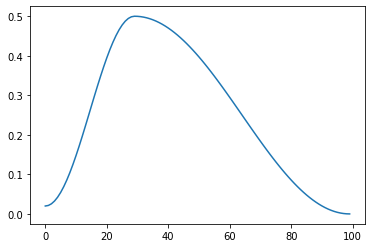

In [ ]:
model_test = torch.nn.Linear(2, 1)
optimizer_ = torch.optim.SGD(model_test.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer_, max_lr=0.5, 
                                                steps_per_epoch=10, 
                                                epochs=10)
lrs = []
for i in range(100): # steps_per_epoch*epochs
    optimizer_.step()
    # 옵티마이저가 한 스탭 진행하고 그 때 사용한 학습률을 리스트에 저장
    lrs.append(optimizer_.param_groups[0]["lr"])
    
    # 스케쥴러 스탭을 실행해서 학습률을 업데이트
    scheduler.step()

# 학습을 마치고 학습률의 변화를 그려봄
plt.plot(lrs)    
plt.show()  

In [ ]:
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.0007, 
    steps_per_epoch=len(train_dl), 
    epochs=epochs)

In [ ]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

In [ ]:
beta = 1.0
cutmix_prob = 0.5

In [ ]:
%%time

torch.cuda.empty_cache()

model.to(device)

running_losses = []

for e in range(epochs):
    running_loss = 0.0
    train_acc = 0.0
    val_acc = 0.0

    model.train()
    corr = 0
    
    tqdm_stream_train = tqdm(train_dl)
    for i, d in enumerate(tqdm_stream_train):
        X_batched = d[0]
        y_batched = d[1] #type(torch.float32)

        X_batched = X_batched.to(device) #cuda()
        y_batched = y_batched.to(device) # (N,), torch.int64

        optimizer.zero_grad()
        
        ##################################################
        # CUT-MIX: https://arxiv.org/abs/1905.04899
        r = np.random.rand(1)
        if beta > 0 and r < cutmix_prob:
            lam = np.random.beta(beta, beta)
            rand_idx = torch.randperm(X_batched.shape[0]).to(device)
            target_a = y_batched
            target_b = y_batched[rand_idx]
            bbx1, bby1, bbx2, bby2 = rand_bbox(X_batched.size(), lam)
            X_batched[:, :, bbx1:bbx2, bby1:bby2] = X_batched[rand_idx, :, bbx1:bbx2, bby1:bby2]
            lam = 1 - ( (bbx2-bbx1)*(bby2-bby1) / (X_batched.shape[-1]*X_batched.shape[-2]) )
            
            y_pred = model(X_batched)
            loss = criterion(y_pred, target_a) * lam + criterion(y_pred, target_b)*(1.-lam)
        ##################################################
        else:
            y_pred = model(X_batched) #.squeeze() #(N,1)->(N,), torch.float32
            loss = criterion(y_pred, y_batched) #(N,100), (N,)
            
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        corr += (torch.argmax(y_pred,dim=-1) == y_batched).sum()

        tqdm_stream_train.set_description(f"Trainning Epoch{e+1:3d}")
        
        scheduler.step()
    
    running_loss = running_loss / len(train_dl)
    running_losses.append(running_loss)
    train_acc = corr / len(train_ds)

    print(f"RESULT Epoch{e+1:3d}, Train Loss:{running_loss:.6f}, Train Acc.:{train_acc:.6f}") #, Valid Acc.:{val_acc:.6f}")

Trainning Epoch  1:   0%|          | 1/334 [00:18<1:44:47, 18.88s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your curr

RESULT Epoch  1, Train Loss:4.707000, Train Acc.:0.013199


Trainning Epoch  2: 100%|██████████| 334/334 [03:06<00:00,  1.79it/s]


RESULT Epoch  2, Train Loss:4.422154, Train Acc.:0.042298


Trainning Epoch  3: 100%|██████████| 334/334 [03:08<00:00,  1.77it/s]


RESULT Epoch  3, Train Loss:3.850327, Train Acc.:0.114744


Trainning Epoch  4: 100%|██████████| 334/334 [03:07<00:00,  1.78it/s]


RESULT Epoch  4, Train Loss:3.207994, Train Acc.:0.218989


Trainning Epoch  5: 100%|██████████| 334/334 [03:06<00:00,  1.79it/s]


RESULT Epoch  5, Train Loss:2.857440, Train Acc.:0.294285


Trainning Epoch  6: 100%|██████████| 334/334 [03:06<00:00,  1.79it/s]


RESULT Epoch  6, Train Loss:2.660771, Train Acc.:0.336883


Trainning Epoch  7: 100%|██████████| 334/334 [03:06<00:00,  1.79it/s]


RESULT Epoch  7, Train Loss:2.649021, Train Acc.:0.338083


Trainning Epoch  8: 100%|██████████| 334/334 [03:08<00:00,  1.77it/s]


RESULT Epoch  8, Train Loss:2.522983, Train Acc.:0.377981


Trainning Epoch  9: 100%|██████████| 334/334 [03:09<00:00,  1.76it/s]


RESULT Epoch  9, Train Loss:2.399679, Train Acc.:0.402580


Trainning Epoch 10: 100%|██████████| 334/334 [03:09<00:00,  1.76it/s]


RESULT Epoch 10, Train Loss:2.395553, Train Acc.:0.415479


Trainning Epoch 11: 100%|██████████| 334/334 [03:10<00:00,  1.76it/s]


RESULT Epoch 11, Train Loss:2.287452, Train Acc.:0.444878


Trainning Epoch 12: 100%|██████████| 334/334 [03:07<00:00,  1.78it/s]


RESULT Epoch 12, Train Loss:2.153199, Train Acc.:0.483576


Trainning Epoch 13: 100%|██████████| 334/334 [03:08<00:00,  1.77it/s]


RESULT Epoch 13, Train Loss:2.103386, Train Acc.:0.487326


Trainning Epoch 14: 100%|██████████| 334/334 [03:10<00:00,  1.75it/s]


RESULT Epoch 14, Train Loss:2.046966, Train Acc.:0.505925


Trainning Epoch 15: 100%|██████████| 334/334 [03:10<00:00,  1.75it/s]


RESULT Epoch 15, Train Loss:1.928533, Train Acc.:0.541023


Trainning Epoch 16: 100%|██████████| 334/334 [03:11<00:00,  1.75it/s]


RESULT Epoch 16, Train Loss:1.837747, Train Acc.:0.560672


Trainning Epoch 17: 100%|██████████| 334/334 [03:11<00:00,  1.74it/s]


RESULT Epoch 17, Train Loss:1.823708, Train Acc.:0.570121


Trainning Epoch 18: 100%|██████████| 334/334 [03:10<00:00,  1.75it/s]


RESULT Epoch 18, Train Loss:1.658591, Train Acc.:0.615569


Trainning Epoch 19: 100%|██████████| 334/334 [03:09<00:00,  1.77it/s]


RESULT Epoch 19, Train Loss:1.645886, Train Acc.:0.606270


Trainning Epoch 20: 100%|██████████| 334/334 [03:09<00:00,  1.76it/s]


RESULT Epoch 20, Train Loss:1.634055, Train Acc.:0.646318


Trainning Epoch 21: 100%|██████████| 334/334 [03:09<00:00,  1.76it/s]


RESULT Epoch 21, Train Loss:1.437746, Train Acc.:0.667317


Trainning Epoch 22: 100%|██████████| 334/334 [03:08<00:00,  1.77it/s]


RESULT Epoch 22, Train Loss:1.441919, Train Acc.:0.674066


Trainning Epoch 23: 100%|██████████| 334/334 [03:07<00:00,  1.79it/s]


RESULT Epoch 23, Train Loss:1.473878, Train Acc.:0.667017


Trainning Epoch 24: 100%|██████████| 334/334 [03:09<00:00,  1.76it/s]


RESULT Epoch 24, Train Loss:1.308369, Train Acc.:0.720114


Trainning Epoch 25: 100%|██████████| 334/334 [03:09<00:00,  1.76it/s]


RESULT Epoch 25, Train Loss:1.199923, Train Acc.:0.737963


Trainning Epoch 26: 100%|██████████| 334/334 [03:05<00:00,  1.80it/s]


RESULT Epoch 26, Train Loss:1.301978, Train Acc.:0.725064


Trainning Epoch 27: 100%|██████████| 334/334 [03:08<00:00,  1.77it/s]


RESULT Epoch 27, Train Loss:1.122624, Train Acc.:0.777561


Trainning Epoch 28: 100%|██████████| 334/334 [03:06<00:00,  1.79it/s]


RESULT Epoch 28, Train Loss:1.121943, Train Acc.:0.762112


Trainning Epoch 29: 100%|██████████| 334/334 [03:09<00:00,  1.76it/s]


RESULT Epoch 29, Train Loss:1.125201, Train Acc.:0.777111


Trainning Epoch 30: 100%|██████████| 334/334 [03:03<00:00,  1.82it/s]

RESULT Epoch 30, Train Loss:1.120794, Train Acc.:0.776511
CPU times: user 39min 14s, sys: 10min 40s, total: 49min 54s
Wall time: 1h 47min 18s


In [ ]:
model.eval(); # efficientnet_b7 = models.efficientnet_b4()
torch.cuda.empty_cache()

In [ ]:
train_dl2 = torch.utils.data.DataLoader(train_ds, batch_size=2,
                                      pin_memory=True)

test_dl = torch.utils.data.DataLoader(test_ds, batch_size=2,
                                      pin_memory=True)

In [ ]:
tqdm_stream_check_train = tqdm(train_dl2)
corr = 0

for j, d in enumerate(tqdm_stream_check_train):
    X_batched = d[0]
    y_batched = d[1]
    
    X_batched = X_batched.to(device) #cuda()
    y_batched = y_batched.to(device) #cuda()

    y_pred = model(X_batched)
    corr += (torch.argmax(y_pred,dim=-1) == y_batched).sum().item()

    tqdm_stream_check_train.set_description("Acc. for TRAIN SET")

Acc. for TRAIN SET: 100%|██████████| 3334/3334 [05:11<00:00, 10.70it/s]


In [ ]:
train_acc = corr / len(train_ds)
train_acc

0.9781010949452528

In [ ]:
tqdm_stream_check_val = tqdm(test_dl)
corr = 0

for j, d in enumerate(tqdm_stream_check_val):
    X_batched = d[0]
    y_batched = d[1]
    
    X_batched = X_batched.to(device) #cuda()
    y_batched = y_batched.to(device) #cuda()

    y_pred = model(X_batched)
    corr += (torch.argmax(y_pred,dim=-1) == y_batched).sum().item()

    tqdm_stream_check_val.set_description("Acc. for TEST SET")

In [ ]:
test_acc = corr / len(test_ds)
test_acc